##HIT Electricity

This notebook will extract typical profiles for use as input for the coupled co-simulation with CitySim

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline 

In [3]:
workingdir = "/Users/millerc/Dropbox/03-ETH/98-UMEM/RawDataAnalysis/"

In [4]:
# os.chdir(workingdir)

In [5]:
df = pd.read_csv(workingdir+"aggset2_QW/HIT_QW.csv", index_col="Date Time", parse_dates=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50144 entries, 2008-04-21 17:00:00 to 2014-01-10 00:00:00
Data columns (total 28 columns):
HITMEL01QW_A [kWh]    46644 non-null float64
HITMEL11QW_A [kWh]    44364 non-null float64
HITMEL12QW_A [kWh]    44364 non-null float64
HITMEL30QW_A [kWh]    47550 non-null float64
HITMEL50QW_A [kWh]    47354 non-null float64
HITMEL60QW_A [kWh]    47354 non-null float64
HITMEL65QW_A [kWh]    47354 non-null float64
HITMEL70QW_A [kWh]    47550 non-null float64
HITMEL71QW_A [kWh]    47354 non-null float64
HITMEL72QW_A [kWh]    47544 non-null float64
HITMEL73QW_A [kWh]    47544 non-null float64
HITMEL74QW_A [kWh]    47550 non-null float64
HITMEL75QW_A [kWh]    44364 non-null float64
HITMEL76QW_A [kWh]    47543 non-null float64
HITMEL77QW_A [kWh]    47291 non-null float64
HITMEL80QW_A [kWh]    46644 non-null float64
HITMHE01QW_A [kWh]    50067 non-null float64
HITMHE10QW_A [kWh]    50067 non-null float64
HITMHE11QW_A [kWh]    45020 non-null float64
H

In [7]:
point = "HITMEL01QW_A [kWh]"

In [8]:
df_QW = pd.DataFrame(df[point].truncate(before='2013',after='2014'))

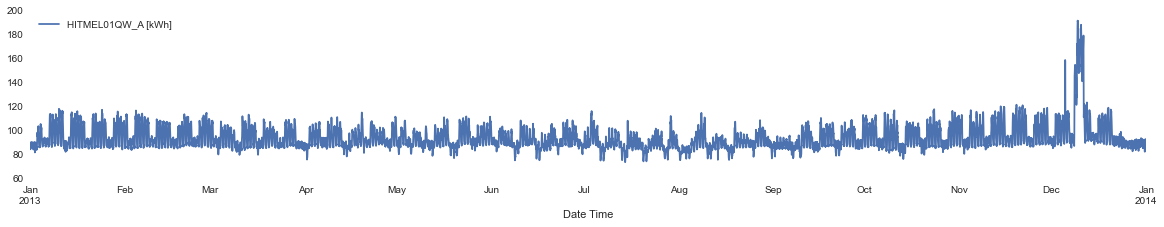

In [9]:
df_QW.plot(figsize=(20,3));

##Convert to SAX

In [10]:
df = df_QW.dropna()

In [11]:
#df.head()

In [12]:
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [13]:
df_pivot = pd.pivot_table(df, values=point, index='Date', columns='Time')

In [14]:
a = 3
w = '4h'

In [15]:
from scipy.stats import norm
import numpy as np
import string

In [16]:
def discretizer(row, breakpoints):
    return np.where(breakpoints > float(row))[0][0]

def stringizer(row):
    return ''.join(string.ascii_letters[int(row['step'])])

def adddate(df):
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    return df

def SAXizer(df, symbol_count, breakfreq):
    x = df.fillna(method='ffill')
    y = (x - x.mean()) / x.std()
    z = pd.DataFrame(y.resample(breakfreq).dropna())
    z.columns = ["numbers"]
    breakpoints = norm.ppf(np.linspace(1./symbol_count, 1-1./symbol_count, symbol_count-1))
    breakpoints = np.concatenate((breakpoints, np.array([np.Inf])))
    
    z['step'] = z.apply(discretizer, axis=1, args=[breakpoints])
    z['letter'] = z.apply(stringizer, axis=1)
    z = adddate(z)
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    
    SAXstrings = zpivot.dropna().sum(axis=1)
    
    return zpivot.dropna(), SAXstrings

In [17]:
df_forSAX = df[point]
zpivot, SAXstrings = SAXizer(df_forSAX, a, w)

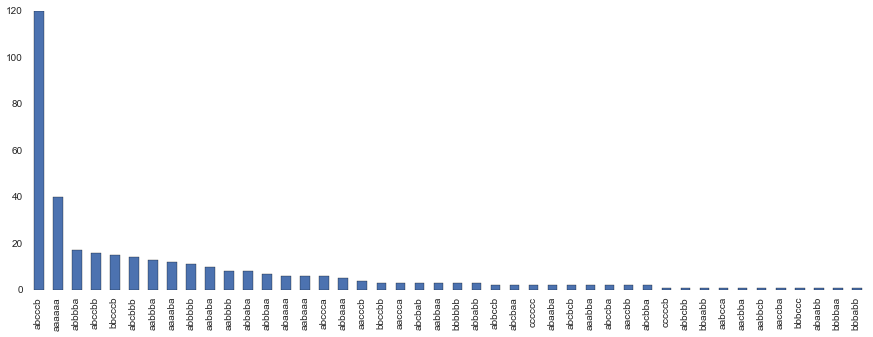

In [18]:
patterncount = SAXstrings.value_counts()
patterncount.plot(kind='bar', figsize=(15,5));

In [19]:
binsizethreshold = 0.02
motifs = patterncount[(patterncount > patterncount.sum() * binsizethreshold)]
motifs

abcccb    120
aaaaaa     40
abbbba     17
abccbb     16
bbcccb     15
abcbbb     14
aabbba     13
aaaaba     12
abbbbb     11
aababa     10
aabbbb      8
abbaba      8
dtype: int64

In [20]:
discords = patterncount[(patterncount < patterncount.sum() * binsizethreshold)]
discords.head()

abbbaa    7
abaaaa    6
aabaaa    6
abccca    6
abbaaa    5
dtype: int64

In [21]:
df_RawAndSAX = pd.concat([df_pivot, pd.DataFrame(SAXstrings, columns=['SAXstring'])], axis=1)

In [22]:
motifdata = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(motifs.index))]

#Cluster!

In [23]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt


In [58]:
df = motifdata.drop(['SAXstring'], axis=1)

In [59]:
df_pivot.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,84.950,86.100,84.35,84.850,85.200,85.350,88.200,89.100,90.47700,90.21100,...,89.59950,89.24475,89.62500,90.000,90.250,89.500,87.275,85.500,85.375,85.350
2013-01-02,86.375,84.075,84.85,85.975,85.725,85.225,87.450,90.125,90.48275,89.02775,...,85.36600,86.81525,89.16050,90.150,90.125,89.875,87.425,85.625,84.500,84.700
2013-01-03,85.325,85.975,83.70,85.200,86.200,84.925,89.325,92.025,97.59450,98.53375,...,100.43775,102.68275,103.72150,102.400,99.550,95.025,90.850,89.050,87.425,86.250
2013-01-04,86.475,86.125,86.35,85.875,87.150,86.125,90.850,94.350,99.94075,102.17175,...,99.59325,102.02500,102.34300,102.525,97.775,96.575,92.150,89.575,88.725,87.925
2013-01-05,87.825,87.525,86.55,87.800,88.175,87.800,89.625,91.425,93.28275,91.70475,...,91.84650,91.16725,93.24875,94.225,93.700,92.050,91.475,89.325,89.050,87.925


In [26]:
df = df_pivot

In [27]:
def timestampcombine_parse(date,time):
    #timestampstring = date+" "+time
#     date = datetime.strptime(date, "%Y-%M-%d")
#     time = datetime.strptime(time, "%H:%M:%S").time()
    pydatetime = datetime.combine(date, time)

    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [28]:
df = df.T.unstack().reset_index()
df['timestampstring'] = map(timestampcombine_parse, df.Date, df.Time)
df.index = df.timestampstring
df = df.drop(['Date','Time','timestampstring'],axis=1)
df.columns = [point]
df = df.resample('H')

In [29]:
df.head()

,HITMEL01QW_A [kWh]
timestampstring,
2013-01-01 00:00:00,84.95
2013-01-01 01:00:00,86.10
2013-01-01 02:00:00,84.35
2013-01-01 03:00:00,84.85
2013-01-01 04:00:00,85.20


In [30]:
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np

In [31]:
df_norm = (df - df.mean()) / (df.max() - df.min()) #normalized

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [32]:
dailyblocks = pd.pivot_table(df, values=point, index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values=point, index='Date', columns='Time', aggfunc='mean')

In [33]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [34]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [35]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 

In [36]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).order()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

In [37]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort()

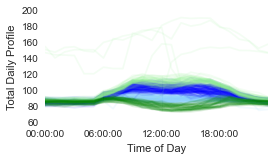

In [38]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 4,2

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 21600))

ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day')
plt.savefig("clusters_total_overlaid_profiles.pdf")

In [39]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = map(timestampcombine, df.Date, df.level_2)
    df = df.dropna()
    return df

In [40]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

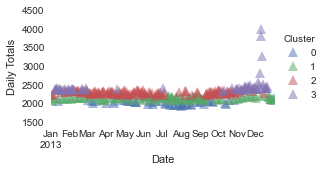

In [41]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

clusteravgplot = dfclusterunstackedpivoted.resample('D', how=np.sum).plot(style="^",markersize=10, alpha=0.5)
clusteravgplot.set_ylabel('Daily Totals')
clusteravgplot.set_xlabel('Date')
clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

plt.savefig("clusters_overtime.pdf")

In [42]:
dailyclusters.head()

ClusterNo2          1                                                         \
Date       2013-01-01 2013-01-02 2013-01-05 2013-01-06 2013-01-13 2013-01-19   
00:00:00        84.95     86.375     87.825     88.025     85.825     86.875   
01:00:00        86.10     84.075     87.525     86.750     85.625     86.525   
02:00:00        84.35     84.850     86.550     87.625     85.350     86.725   
03:00:00        84.85     85.975     87.800     86.525     84.600     86.375   
04:00:00        85.20     85.725     88.175     87.125     85.225     86.225   

ClusterNo2                                                ...              0  \
Date       2013-01-20 2013-01-26 2013-01-27 2013-02-02    ...     2013-09-01   
00:00:00       85.350     86.900     85.250     86.050    ...        86.0500   
01:00:00       85.475     86.900     87.125     85.150    ...        85.9875   
02:00:00       85.600     87.525     86.875     86.025    ...        85.3375   
03:00:00       85.475     86.275     86.500     84.650    ...        85.6500   
04:00:00       84.700     86.150     86.500     85.375    ...        85.4750   

ClusterNo2                                                                    \
Date       2013-09-07 2013-09-14 2013-09-15 2013-09-21 2013-09-22 2013-10-12   
00:00:00      84.0750    86.7000    84.8375    88.4125    85.5875    84.0000   
01:00:00      81.3250    85.1500    84.0000    87.6500    85.8000    83.5000   
02:00:00      79.6875    85.5250    85.0250    86.4375    85.9750    83.3625   
03:00:00      82.7125    83.9000    84.5250    87.5250    87.0250    83.3500   
04:00:00      84.3250    85.2625    84.0125    87.2000    86.0375    82.8375   

ClusterNo2                                   
Date       2013-10-13 2013-10-19 2013-10-26  
00:00:00      82.6125    87.1500    86.6375  
01:00:00      82.1375    86.8500    86.9125  
02:00:00      83.6750    87.0875    87.2125  
03:00:00      84.4000    88.4375    86.2500  
04:00:00      83.2125    86.9500    86.9500  

[5 rows x 364 columns]

In [43]:
calendar = dfclusterunstackedpivoted.resample('D', how=np.sum)
calendar.head()

ClusterNo2,0,1,2,3
timestampstring,,,,
2013-01-01,NaN,2104.05800,NaN,NaN
2013-01-02,NaN,2086.20650,NaN,NaN
2013-01-03,NaN,NaN,2232.2355,NaN
2013-01-04,NaN,NaN,2271.1950,NaN
2013-01-05,NaN,2167.48975,NaN,NaN


In [44]:
calendar.to_csv("calendar.csv")

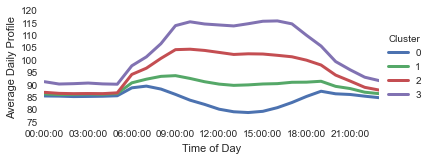

In [45]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(6,2),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("clusters_averagedprofiles.pdf")

In [46]:
dfclusterunstackedpivoted.groupby('Time').max().max().max()

191.95351560906997

In [92]:
#dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
normalizedprofiles = dfclusterunstackedpivoted.groupby('Time').mean() / (dfclusterunstackedpivoted.groupby('Time').max().max().max()*0.7)

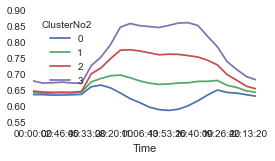

In [93]:
normalizedprofiles = normalizedprofiles.fillna(0)
normalizedprofiles.plot()

In [94]:
normalizedprofiles.to_csv("Schedules.csv")

In [95]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

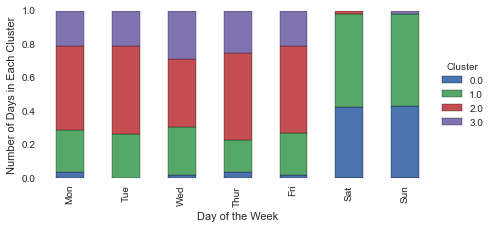

In [96]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsCluster = DayVsCluster.T/DayVsCluster.T.sum()
DayVsCluster = DayVsCluster.T
DayVsClusterplot1 = DayVsCluster.plot(figsize=(7,3), kind='bar', stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("clusters_dailybreakdown.pdf")

In [97]:
DayVsCluster

ClusterNo2,0.0,1.0,2.0,3.0
Mon,0.038462,0.250000,0.500000,0.211538
Tue,NaN,0.264151,0.528302,0.207547
Wed,0.019231,0.288462,0.403846,0.288462
Thur,0.038462,0.192308,0.519231,0.250000
Fri,0.019231,0.250000,0.519231,0.211538
Sat,0.423077,0.557692,0.019231,NaN
Sun,0.431373,0.549020,NaN,0.019608


##Create Graphics for JBPS Paper

First load the resultant data from the analysis so no need to rerun:

In [98]:
normalizedprofiles = pd.read_csv("Schedules.csv", index_col='Time')

In [99]:
normalizedprofiles.head()

,0,1,2,3
Time,,,,
00:00:00,0.638711,0.645010,0.649630,0.681483
01:00:00,0.638192,0.642890,0.646534,0.674539
02:00:00,0.636875,0.643543,0.645633,0.675610
03:00:00,0.637267,0.644538,0.646009,0.677475
04:00:00,0.637855,0.643748,0.645649,0.674889


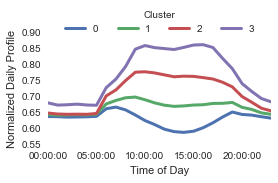

In [100]:
dailyprofile = normalizedprofiles.plot(figsize=(4,2),linewidth=3)
dailyprofile.set_ylabel('Normalized Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center', bbox_to_anchor=(0.5, 1.1), title='Cluster', ncol=4)
plt.savefig("clusters_averagedprofiles_normalized.pdf")

###The Cal-Heatmap setup

In [60]:
calendar = pd.read_csv("calendar.csv", index_col='timestampstring', parse_dates=True)

In [61]:
#calendar.fillna(0).dropna(how="all").info()

In [62]:
import time

In [63]:
calendar['epochtime'] = calendar.index.map(lambda x: int(time.mktime(x.timetuple())))
calendar.index = calendar.epochtime

In [64]:
calendar.head()

,0,1,2,3,epochtime
epochtime,,,,,
1356994800,NaN,2104.05800,NaN,NaN,1356994800
1357081200,NaN,2086.20650,NaN,NaN,1357081200
1357167600,NaN,NaN,2232.2355,NaN,1357167600
1357254000,NaN,NaN,2271.1950,NaN,1357254000
1357340400,NaN,2167.48975,NaN,NaN,1357340400


In [65]:
calendar = calendar.drop(['epochtime'], axis=1)

In [66]:
calendar.head()

,0,1,2,3
epochtime,,,,
1356994800,NaN,2104.05800,NaN,NaN
1357081200,NaN,2086.20650,NaN,NaN
1357167600,NaN,NaN,2232.2355,NaN
1357254000,NaN,NaN,2271.1950,NaN
1357340400,NaN,2167.48975,NaN,NaN


In [67]:
cal_heatmap = calendar.unstack().dropna().reset_index()

In [68]:
cal_heatmap.head()

,level_0,epochtime,0
0,0,1357945200,2080.02375
1,0,1362265200,2103.75700
2,0,1362783600,2068.31450
3,0,1362870000,2026.01475
4,0,1363388400,2079.87450


In [69]:
cal_heatmap.index = cal_heatmap.epochtime

In [70]:
cal_heatmap.head()

,level_0,epochtime,0
epochtime,,,
1357945200,0,1357945200,2080.02375
1362265200,0,1362265200,2103.75700
1362783600,0,1362783600,2068.31450
1362870000,0,1362870000,2026.01475
1363388400,0,1363388400,2079.87450


In [71]:
cal_heatmap = cal_heatmap.drop(['epochtime',0], axis=1)

In [72]:
cal_heatmap = cal_heatmap.sort()

In [73]:
cal_heatmap.level_0 = cal_heatmap.level_0.astype("float")

In [74]:
cal_heatmap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 1356994800 to 1388444400
Data columns (total 1 columns):
level_0    364 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [75]:
cal_heatmap.head()

,level_0
epochtime,
1356994800,1
1357081200,1
1357167600,2
1357254000,2
1357340400,1


In [76]:
cal_heatmap = cal_heatmap+1

In [77]:
cal_heatmap.head()

,level_0
epochtime,
1356994800,2
1357081200,2
1357167600,3
1357254000,3
1357340400,2


In [78]:
cal_heatmap.level_0.to_json("hit_cal_heatmap.json")

In [79]:
x = sns.color_palette()

In [80]:
import matplotlib.colors as colors

In [81]:
for color in x:
    print colors.rgb2hex(color)

#4c72b0
#55a868
#c44e52
#8172b2
#ccb974
#64b5cd
